## Cables

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/cables.ipynb) (requires google account)


TOPFARM can use the Electrical Network Design package EDWIN to optimize the carray cabels as well as the substation position at each iteration of the layout optimization

### Import

In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm._topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.plotting import XYPlotComp
from topfarm.utils import plot_list_recorder
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation

from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines
from py_wake import BastankhahGaussian
from py_wake.examples.data.hornsrev1 import Hornsrev1Site

from optiwindnet.api import WindFarmNetwork, Heuristic, MILP

load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\ortools.dll...


### Site

In [2]:
n_wt = 30
initial = np.asarray([np.random.random(30)*6000, np.random.random(30)*-10000]).T
x_init = initial[:,0]
y_init = initial[:,1]
boundary = np.array([(0, 0), (6000, 0), (6000, -10000), (0, -10000)])  # turbine boundaries
drivers = [EasyScipyOptimizeDriver(maxiter=10)]
windTurbines = IEA37_WindTurbines()
site = Hornsrev1Site()
wfm = BastankhahGaussian(site, windTurbines)


c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\py_wake\deficit_models\gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


### Bathymetry

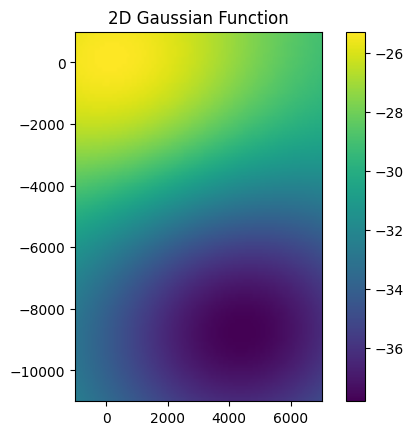

In [3]:
sigma = 3000.0
mu = 0.0

x_peak_1 = 1000
y_peak_1 = -1000
x_peak_2 = 4000
y_peak_2 = -8000
x1, y1 = np.meshgrid(np.linspace(0 - x_peak_1, 6000- x_peak_1, 100), np.linspace(-10000 - y_peak_1, 0 - y_peak_1, 100))
d1 = np.sqrt(x1*x1 + y1*y1)
g1 = np.exp(-((d1 - mu)**2 / (2.0 * sigma**2)))
x2, y2 = np.meshgrid(np.linspace(0 - x_peak_2, 6000- x_peak_2, 100), np.linspace(-10000 - y_peak_2, 0 - y_peak_2, 100))
d2 = np.sqrt(x2*x2 + y2*y2)
g2 = np.exp(-((d2 - mu)**2 / (2.0 * sigma**2)))
g = 5 * g1 - 8 * g2 - 30

plt.imshow(g, extent=(-1000, 7000, -11000, 1000), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('2D Gaussian Function')
plt.show()

x = np.linspace(-1000, 7000, 100)
y = np.linspace(-11000, 1000, 100)

f = RegularGridInterpolator((x, y), g)

### Cables

<Axes: >

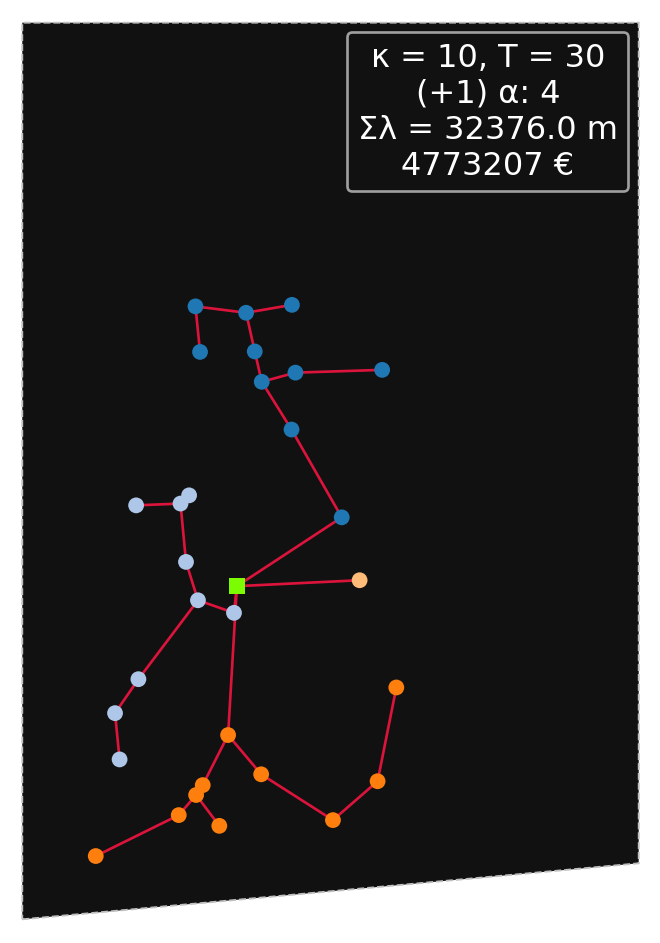

In [4]:
x_ss_init = x_init.mean()
y_ss_init = y_init.mean()
turbines_pos=  np.column_stack((x_init, y_init))
substations_pos =  np.column_stack((x_ss_init, y_ss_init))

cables = np.array([(3, 100),(5, 150), (10, 250)])  # Here you set up cables [<cable cross section>, <number of turbines can be connected>, <price in € per meter>]


# 'obstacles' is an optional location attribute
obstacles = []

border =  np.array(
    [[-1000, -11000], [10000, -10000], [10000, 5000], [-1000, 5000]],
    dtype=float)

wfn = WindFarmNetwork(turbines=turbines_pos, substations=substations_pos, cables=cables, border=border, obstacles=obstacles)
router_pre_solver = Heuristic(solver='Esau_Williams')
res_pre_solver= wfn.optimize(router=router_pre_solver)
#G = wfn.optimize(turbines_pos)
cable_cost_ref = wfn.cost() # euro
cable_length_ref = wfn.length()  # m
cost_per_length_ref = cable_cost_ref / cable_length_ref # euro / m

wfn.plot()

### Economy

In [5]:
Drotor_vector = [windTurbines.diameter()] * n_wt
power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt
hub_height_vector = [windTurbines.hub_height()] * n_wt

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.1               # [Euro/kWh] What we get per kWh
project_duration = 25            # [years]
rated_rpm_array = [12] * n_wt    # [rpm]
simres = wfm(x_init, y_init)
aep = simres.aep().values.sum()
CF = aep / (windTurbines.power(20)*1e-9 * 24*365*n_wt)

eco_eval = economic_evaluation(distance_from_shore, energy_price, project_duration)
npv_ref = eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, 30, aep/n_wt * np.ones(n_wt)*10**6, cabling_cost=cable_cost_ref)

### Python Functions

In [6]:
# Water Depth
def water_depth_func(x, y, **kwargs):
    xnew, ynew = np.meshgrid(x, y)
    points = np.array([xnew.flatten(), ynew.flatten()]).T
    return - np.diag(f(points).reshape(n_wt, n_wt).T)

# Cables
def cable_func(x, y, x_substation, y_substation, **kwargs):
    wfn.optimize(turbines= np.column_stack((x, y)), substations= np.column_stack((float(x_substation[0]), float(y_substation[0]))), router=router_pre_solver)

    return wfn.cost(), {'cabling_length': wfn.length()}

# Economy
def npv_func(AEP, water_depth, cabling_cost, **kwargs):
    eco_eval.calculate_npv(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth, AEP/n_wt * np.ones(n_wt)*10**6, cabling_cost=cabling_cost)
    CAPEX = eco_eval.project_costs_sums["CAPEX"]
    OPEX = eco_eval.project_costs_sums["OPEX"]
    return eco_eval.NPV, {'irr': eco_eval.IRR,
                          'OPEX': OPEX,
                          'CAPEX': CAPEX,}


### Components

In [7]:
# Water Depth
water_depth_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=water_depth_func,
                                          objective=False,
                                          output_keys=[('water_depth', np.zeros(n_wt))])

# Cables
cable_component = CostModelComponent(input_keys=[('x', x_init),('y', y_init), ('x_substation', x_ss_init), ('y_substation', y_ss_init)],
                                     n_wt=n_wt,
                                     cost_function=cable_func,
                                     objective=False,
                                     output_keys=[('cabling_cost', 0)], # network rather than network
                                     additional_output=[('cabling_length', 0)])

# Economy
npv_comp = CostModelComponent(input_keys=[('AEP', 0), ('water_depth', 30*np.ones(n_wt)), ('cabling_cost', 100000)],
                              n_wt=n_wt,
                              cost_function=npv_func,
                              objective=True,
                              maximize=True,
                              output_keys=[('npv', 0)],
                              additional_output=[('irr', 0),
                                                 ('CAPEX', 0),
                                                 ('OPEX', 0)])

# AEP
aep_comp = PyWakeAEPCostModelComponent(wfm, n_wt, objective=False)

### Problem Assembly

In [8]:
cost_comp = TopFarmGroup([PyWakeAEPCostModelComponent(wfm, n_wt, objective=False), water_depth_component, cable_component, npv_comp])


tf = TopFarmProblem(
    design_vars=dict(zip('xy', initial.T), x_substation=x_ss_init, y_substation=y_ss_init),
    cost_comp=cost_comp,
    constraints=[XYBoundaryConstraint(boundary),
                 SpacingConstraint(500)
                 ],
    driver=drivers[0],
    plot_comp=XYPlotComp()
)


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.001501 sec).
INFO: checking system...
INFO:     system check complete (0.000074 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000438 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000162 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000016 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000542 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000225 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000009 sec).


### Optimize

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000633 sec).
INFO: checking system...
INFO:     system check complete (0.000084 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000471 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000143 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000013 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000513 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000135 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000009 sec).


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


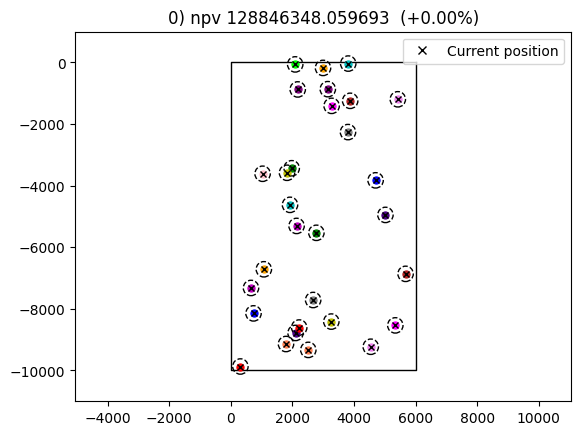

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Iteration limit reached    (Exit mode 9)
            Current function value: -145895280.1717075
            Iterations: 10
            Function evaluations: 13
            Gradient evaluations: 10
Optimization FAILED.
Iteration limit reached
-----------------------------------


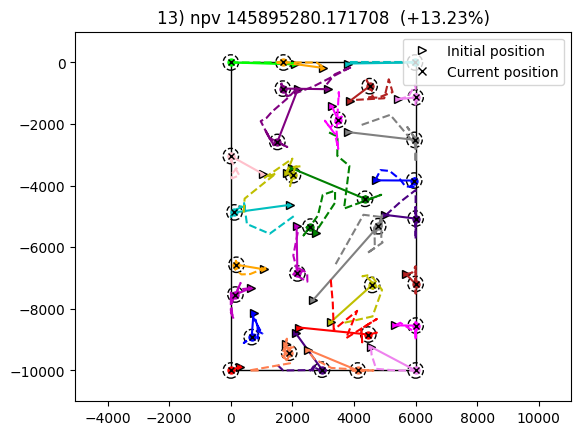

In [9]:
cost, _, recorder = tf.optimize()


### Plot

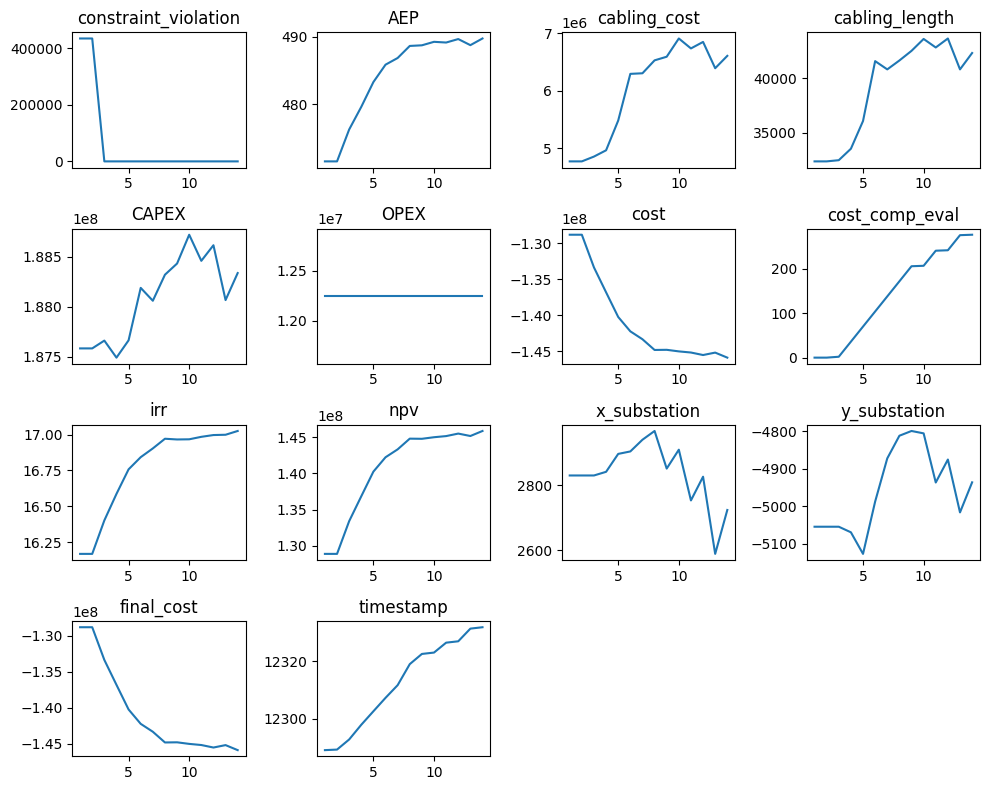

In [10]:
plot_list_recorder(recorder)


Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 40 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model '': (model_fingerprint: 0x6c47c94de9fad9a6)
#Variables: 512 (#bools: 143 in floating point objective)
  - 369 Booleans in [0,1]
  - 113 in [-9,9]
  - 30 in [0,10]
#kAtMostOne: 108 (#literals: 423)
#kLinear1: 738 (#enforced: 738)
#kLinearN: 33 (#terms: 459)

Starting presolve at 0.02s
[Scaling] Floating point objective has 143 terms with magnitude in [416.788, 6031.08] average = 2747
[Scaling] Objective coefficient relative error: 2.22287e-09
[Scaling] Objective worst-case absolute error: 6.80847e-05
[Scaling] Objective scaling factor: 262144
  3.52e-04s  0.00e+00d  [DetectDominanceRelations] 
  9.44e-03s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  8.77e-05s  0.00e+00d  [operations_research::sat::CpModelPresolver::ExtractEncodingFromLinear] #potentia

<Axes: >

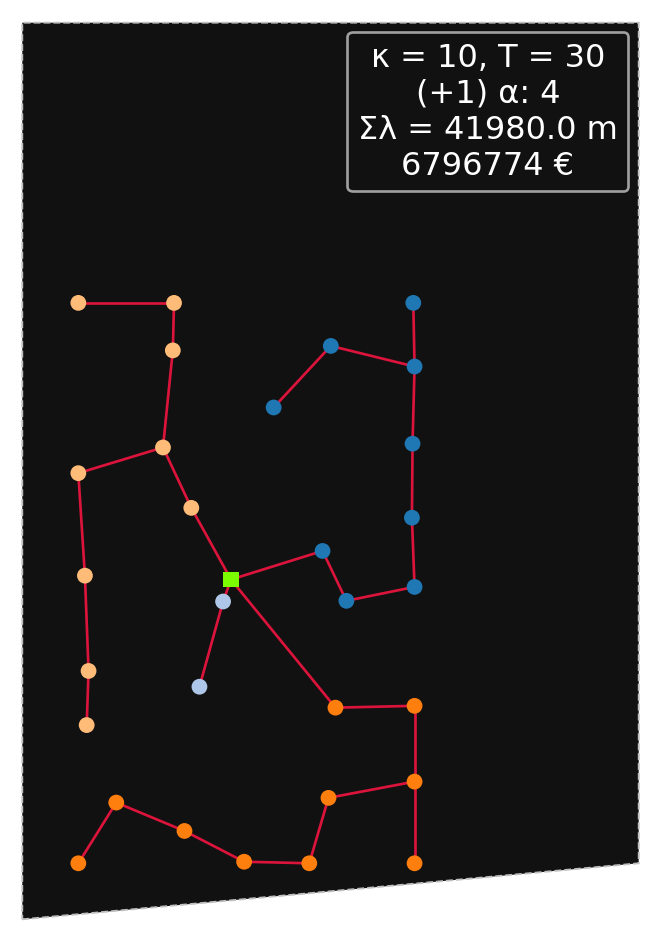

In [12]:
x_opt = recorder['x'][-1]
y_opt = recorder['y'][-1]
x_sub_opt = recorder['x_substation'][-1]
y_sub_opt = recorder['y_substation'][-1]

solver_options=dict(
    max_time_in_seconds = 40,
    relative_gap_limit = 0.005,
    num_workers = 8,

# be verbose
log_search_progress = True,
# required to get the log inside the notebook (goes only to console otherwise)
log_callback = print,
)


model_options = {"gateXing_constraint": False,
                 "branching": True,
                 "gates_limit": False}

router = MILP(solver='ortools', solver_options=solver_options, model_options=model_options, detour=True)
res =wfn.optimize(turbines= np.column_stack((x_opt, y_opt)), substations= np.column_stack((float(x_sub_opt), float(y_sub_opt))), router=router)
wfn.plot() # check the plot